In [23]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
import os
import scipy.signal
import neurokit2 as nk
from sklearn.utils import shuffle

In [2]:
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras import regularizers


from keras.optimizers import Adam
from keras.models import load_model
from keras.models import Model
import keras.metrics
from keras.callbacks import ModelCheckpoint

In [3]:
path, dirs, files = next(os.walk("./Data_preprocessed/"))
#path, dirs, files = next(os.walk("./Data2/"))
nod=len(dirs)

In [4]:
from skimage.transform import resize
def df_resample(df1, num=1):
    df2 = pd.DataFrame()
    for key, value in df1.iteritems(): 
        temp = value.to_numpy()/value.abs().max() # normalize
        resampled = resize(temp, (num,1), mode='edge')*value.abs().max() # de-normalize
        df2[key] = resampled.flatten().round(2)
    return df2

In [51]:
dataframes_list_test = list()
labels_list_test = list()
dataframes_list_train = list()
labels_list_train = list()
for j in range(nod):
    c_path=os.path.join(path, dirs[j])
    print(j)
    print(c_path)
    c_path, c_dirs, c_files = next(os.walk(c_path))
    file_count = len(c_files)
    print(file_count)
    # create empty list

    # append datasets to the list
    for i in range(file_count):
        temp_df = pd.read_csv(c_path + '/' + c_files[i])
        #temp_df= temp_df.drop(['NUM','DATE'],axis=1)
        #temp_df = df_resample(temp_df, 500) # resampling rate is 500
        #temp_df=temp_df.drop("Unnamed: 0",axis=1)
        #temp_df.columns.str.match("Unnamed")
        temp_df=temp_df.loc[:,~temp_df.columns.str.match("Unnamed")]

        
        if i % 10 == 0:  #every 10th measurement goes into the train set
            dataframes_list_test.append(temp_df)
            labels_list_test.append(j)
        else:
            dataframes_list_train.append(temp_df)
            labels_list_train.append(j)

0
./Data_preprocessed/Left_Crossing
100
1
./Data_preprocessed/Left_Roundabout
100
2
./Data_preprocessed/Parking_Diagonal_Left
100
3
./Data_preprocessed/Parking_Diagonal_Right
100
4
./Data_preprocessed/Parking_Parallel_Left
100
5
./Data_preprocessed/Parking_Parallel_Right
100
6
./Data_preprocessed/Parking_Perpendicular_Left
100
7
./Data_preprocessed/Parking_Perpendicular_Right
100
8
./Data_preprocessed/Right_Crossing
100
9
./Data_preprocessed/Right_Roundabout
100
10
./Data_preprocessed/Straight_Crossing
100
11
./Data_preprocessed/Straight_Roundabout
100


In [ ]:
temp_df

In [52]:
len_sequences = []
for one_seq in dataframes_list_train:
    len_sequences.append(len(one_seq))
pd.Series(len_sequences).describe()

count    1080.0
mean      500.0
std         0.0
min       500.0
25%       500.0
50%       500.0
75%       500.0
max       500.0
dtype: float64

In [53]:
train = np.array(dataframes_list_train)
#validation = np.array(dataframes_list_test)
test = np.array(dataframes_list_test)
train_target = np.array(labels_list_train)
#train_target = (train_target+1)/2

#validation_target = np.array(labels_list_test)
#validation_target = (validation_target+1)/2

test_target = np.array(labels_list_test)
#test_target = (test_target+1)/2
 

In [ ]:
model.summary()

In [10]:
import tensorflow_addons as tfa
from keras import backend as K
# RNN Layers
# Define input layer
recurrent_input = Input(shape=(500,11),name='TIMESERIES_INPUT')

# layer - 1

rec_layer_one = Bidirectional(LSTM(50, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01),return_sequences=True),name ='BIDIRECTIONAL_LAYER_1')(recurrent_input)

rec_layer_one = Dropout(0.1,name ='DROPOUT_LAYER_1')(rec_layer_one)

# layer - 2

rec_layer_two = Bidirectional(LSTM(50, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01)),name ='BIDIRECTIONAL_LAYER_2')(rec_layer_one)

rec_layer_two = Dropout(0.1,name ='DROPOUT_LAYER_2')(rec_layer_two)

# Combine layers - RNN + SLP

combined_dense_two = Dense(64, activation='relu',name='DENSE_LAYER_2')(rec_layer_two)

output = Dense(12,activation='sigmoid',name='OUTPUT_LAYER')(combined_dense_two)

# Compile Model

model1 = Model(inputs=[recurrent_input],outputs=[output])

# binary cross entropy loss

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

# focal loss

def focal_loss_custom(alpha, gamma):

    def binary_focal_loss(y_true, y_pred):

        fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)

        y_true_K = K.ones_like(y_true)

        focal_loss = fl(y_true, y_pred)

        return focal_loss

    return binary_focal_loss

model1.compile(loss=focal_loss_custom(alpha=0.2, gamma=2.0), optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 TIMESERIES_INPUT (InputLaye  [(None, 500, 11)]        0         
 r)                                                              
                                                                 
 BIDIRECTIONAL_LAYER_1 (Bidi  (None, 500, 100)         24800     
 rectional)                                                      
                                                                 
 DROPOUT_LAYER_1 (Dropout)   (None, 500, 100)          0         
                                                                 
 BIDIRECTIONAL_LAYER_2 (Bidi  (None, 100)              60400     
 rectional)                                                      
                                                                 
 DROPOUT_LAYER_2 (Dropout)   (None, 100)               0         
                                                           

In [9]:
# Define metrics for evaluating the model - recall, precision and f1-score

def recall_m(y_true, y_pred):

   true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

   possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

   recall = true_positives / (possible_positives + K.epsilon())

   return recall

def precision_m(y_true, y_pred):

   true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

   predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

   precision = true_positives / (predicted_positives + K.epsilon())

   return precision

def f1_m(y_true, y_pred):

   precision = precision_m(y_true, y_pred)

   recall = recall_m(y_true, y_pred)

   return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [30]:
# fit network


history1 =  model1.fit(train, train_target, epochs=200, batch_size=64, verbose=1, validation_split=0.2)

Epoch 1/200
14/14 [==============================] - 37s 1s/step - loss: -323308.0312 - accuracy: 0.0799 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316199.6250 - val_accuracy: 0.0750 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 20s 1s/step - loss: -323308.0000 - accuracy: 0.0671 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316199.6250 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/200
14/14 [==============================] - 21s 1s/step - loss: -323308.0625 - accuracy: 0.0799 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316199.6250 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/200
14/14 [==============================] - 20s 1s/step - loss: -323308.0000 - accuracy:

14/14 [==============================] - 21s 1s/step - loss: -323308.1562 - accuracy: 0.0752 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316199.7812 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 29/200
14/14 [==============================] - 20s 1s/step - loss: -323308.1875 - accuracy: 0.0799 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316199.7812 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 30/200
14/14 [==============================] - 21s 1s/step - loss: -323308.1875 - accuracy: 0.0845 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316199.7812 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 31/200
14/14 [==============================] - 21s 2s/step - loss: -323308.1562 - accuracy: 0.0741 -

14/14 [==============================] - 19s 1s/step - loss: -323308.2812 - accuracy: 0.0752 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316199.9688 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 56/200
14/14 [==============================] - 19s 1s/step - loss: -323308.3438 - accuracy: 0.0752 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316199.9688 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 57/200
14/14 [==============================] - 19s 1s/step - loss: -323308.3438 - accuracy: 0.0799 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316199.9688 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 58/200
14/14 [==============================] - 18s 1s/step - loss: -323308.3438 - accuracy: 0.0752 -

14/14 [==============================] - 21s 2s/step - loss: -323308.4688 - accuracy: 0.0764 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316200.0938 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 83/200
14/14 [==============================] - 21s 2s/step - loss: -323308.4688 - accuracy: 0.0775 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316200.0938 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 84/200
14/14 [==============================] - 22s 2s/step - loss: -323308.4688 - accuracy: 0.0775 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316200.0938 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 85/200
14/14 [==============================] - 25s 2s/step - loss: -323308.5312 - accuracy: 0.0787 -

14/14 [==============================] - 20s 1s/step - loss: -323308.6250 - accuracy: 0.0903 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316200.2188 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 110/200
14/14 [==============================] - 22s 2s/step - loss: -323308.6250 - accuracy: 0.0729 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316200.2812 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 111/200
14/14 [==============================] - 25s 2s/step - loss: -323308.6250 - accuracy: 0.0810 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316200.2812 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 112/200
14/14 [==============================] - 24s 2s/step - loss: -323308.6562 - accuracy: 0.086

14/14 [==============================] - 16s 1s/step - loss: -323308.7812 - accuracy: 0.0856 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316200.4062 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 137/200
14/14 [==============================] - 17s 1s/step - loss: -323308.7812 - accuracy: 0.0752 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316200.4062 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 138/200
14/14 [==============================] - 17s 1s/step - loss: -323308.7812 - accuracy: 0.0822 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316200.4062 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 139/200
14/14 [==============================] - 18s 1s/step - loss: -323308.7812 - accuracy: 0.071

14/14 [==============================] - 17s 1s/step - loss: -323308.9375 - accuracy: 0.0764 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316200.5312 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 164/200
14/14 [==============================] - 16s 1s/step - loss: -323308.8750 - accuracy: 0.0741 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316200.5312 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 165/200
14/14 [==============================] - 17s 1s/step - loss: -323308.9375 - accuracy: 0.0683 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: -316200.5312 - val_accuracy: 0.0833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 166/200
14/14 [==============================] - 17s 1s/step - loss: -323308.9375 - accuracy: 0.081

KeyboardInterrupt: 

In [ ]:
# fit network


history1 =  model1.fit([train], train_target, epochs=200, batch_size=64, verbose=1, validation_data=([test],test_target))

In [ ]:
# fit network


history =  model.fit([train], train_target, epochs=200, batch_size=64, verbose=1, validation_data=([test],test_target))



In [ ]:
model1.summary()

In [ ]:
history2 = model.fit(
    train,
    train_target,
    batch_size=64,
    epochs=200,
    callbacks=callbacks,
    validation_split=0.1,
    verbose=1,
)

In [ ]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')

plt.show()

# summarize history for loss

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')

plt.show()

#evaluate model

loss, accuracy, f1_score, precision, recall = model.evaluate([np.asarray(test).astype('float32')], test_target, batch_size=32, verbose=0)

#print output

print("Accuracy:{} , F1_Score:{}, Precision:{}, Recall:{}".format(accuracy, f1_score, precision, recall))

In [ ]:
# summarize history for accuracy

plt.plot(history1.history['sparse_categorical_accuracy'])

plt.plot(history1.history['val_sparse_categorical_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')

plt.show()

# summarize history for loss

plt.plot(history1.history['loss'])

plt.plot(history1.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')

plt.show()

#evaluate model

loss, accuracy, f1_score, precision, recall = model.evaluate([np.asarray(test).astype('float32')], test_target, batch_size=32, verbose=0)

#print output

print("Accuracy:{} , F1_Score:{}, Precision:{}, Recall:{}".format(accuracy, f1_score, precision, recall))

In [ ]:
test_loss, test_acc = model.evaluate(test, test_target)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

In [ ]:
model2 = Sequential()
model2.add(LSTM(100, input_shape = (500, 11)))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation="sigmoid"))
model2.compile(loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy], optimizer="adam")

model2.summary()

In [ ]:
model2.fit(train, train_target, batch_size=64, epochs=50,validation_data=(test,test_target))

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

1080

In [54]:
train, train_target = shuffle(train, train_target)
test, test_target = shuffle(test, test_target)

In [ ]:
model3.summary()

In [55]:

num_classes = len(np.unique(train_target))
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    #conv1 = keras.layers.Dropout(0.1)(conv1)

    conv2 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    #conv2 = keras.layers.Dropout(0.1)(conv2)

    conv3 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model3 = make_model(input_shape=train.shape[1:])
#keras.utils.plot_model(model, show_shapes=True)

In [56]:
epochs = 400
batch_size = 64

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_v64N.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model3.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history3 = model3.fit(
    train,
    train_target,
    shuffle=True,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/400
14/14 [==============================] - 23s 485ms/step - loss: 2.4439 - sparse_categorical_accuracy: 0.1088 - val_loss: 2.9026 - val_sparse_categorical_accuracy: 0.0880 - lr: 0.0010
Epoch 2/400
14/14 [==============================] - 6s 460ms/step - loss: 2.2878 - sparse_categorical_accuracy: 0.2106 - val_loss: 2.6022 - val_sparse_categorical_accuracy: 0.0648 - lr: 0.0010
Epoch 3/400
14/14 [==============================] - 6s 461ms/step - loss: 2.2020 - sparse_categorical_accuracy: 0.2442 - val_loss: 2.4893 - val_sparse_categorical_accuracy: 0.0880 - lr: 0.0010
Epoch 4/400
14/14 [==============================] - 6s 455ms/step - loss: 2.0783 - sparse_categorical_accuracy: 0.2870 - val_loss: 2.3797 - val_sparse_categorical_accuracy: 0.1111 - lr: 0.0010
Epoch 5/400
14/14 [==============================] - 6s 445ms/step - loss: 1.9991 - sparse_categorical_accuracy: 0.2951 - val_loss: 2.2899 - val_sparse_categorical_accuracy: 0.1852 - lr: 0.0010
Epoch 6/400
14/14 [==========

14/14 [==============================] - 6s 444ms/step - loss: 1.0822 - sparse_categorical_accuracy: 0.6366 - val_loss: 1.5550 - val_sparse_categorical_accuracy: 0.5231 - lr: 0.0010
Epoch 44/400
14/14 [==============================] - 6s 450ms/step - loss: 1.0663 - sparse_categorical_accuracy: 0.6481 - val_loss: 1.5310 - val_sparse_categorical_accuracy: 0.4769 - lr: 0.0010
Epoch 45/400
14/14 [==============================] - 6s 443ms/step - loss: 1.0952 - sparse_categorical_accuracy: 0.6366 - val_loss: 1.5431 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 46/400
14/14 [==============================] - 6s 434ms/step - loss: 1.0711 - sparse_categorical_accuracy: 0.6505 - val_loss: 1.5947 - val_sparse_categorical_accuracy: 0.4537 - lr: 0.0010
Epoch 47/400
14/14 [==============================] - 6s 436ms/step - loss: 1.0285 - sparse_categorical_accuracy: 0.6620 - val_loss: 1.6112 - val_sparse_categorical_accuracy: 0.4583 - lr: 0.0010
Epoch 48/400
14/14 [==================

14/14 [==============================] - 6s 441ms/step - loss: 0.7313 - sparse_categorical_accuracy: 0.7639 - val_loss: 1.4586 - val_sparse_categorical_accuracy: 0.5093 - lr: 0.0010
Epoch 86/400
14/14 [==============================] - 6s 461ms/step - loss: 0.6989 - sparse_categorical_accuracy: 0.7986 - val_loss: 1.4822 - val_sparse_categorical_accuracy: 0.5324 - lr: 0.0010
Epoch 87/400
14/14 [==============================] - 7s 467ms/step - loss: 0.7021 - sparse_categorical_accuracy: 0.7720 - val_loss: 1.4058 - val_sparse_categorical_accuracy: 0.5926 - lr: 0.0010
Epoch 88/400
14/14 [==============================] - 6s 448ms/step - loss: 0.7285 - sparse_categorical_accuracy: 0.7627 - val_loss: 1.5195 - val_sparse_categorical_accuracy: 0.5370 - lr: 0.0010
Epoch 89/400
14/14 [==============================] - 6s 437ms/step - loss: 0.6957 - sparse_categorical_accuracy: 0.7720 - val_loss: 1.5105 - val_sparse_categorical_accuracy: 0.5694 - lr: 0.0010
Epoch 90/400
14/14 [==================

Epoch 127/400
14/14 [==============================] - 6s 435ms/step - loss: 0.4167 - sparse_categorical_accuracy: 0.8947 - val_loss: 1.3823 - val_sparse_categorical_accuracy: 0.6343 - lr: 5.0000e-04
Epoch 128/400
14/14 [==============================] - 6s 441ms/step - loss: 0.4377 - sparse_categorical_accuracy: 0.8773 - val_loss: 1.4735 - val_sparse_categorical_accuracy: 0.6343 - lr: 5.0000e-04
Epoch 129/400
14/14 [==============================] - 6s 435ms/step - loss: 0.4652 - sparse_categorical_accuracy: 0.8750 - val_loss: 1.4150 - val_sparse_categorical_accuracy: 0.6204 - lr: 5.0000e-04
Epoch 130/400
14/14 [==============================] - 6s 438ms/step - loss: 0.4340 - sparse_categorical_accuracy: 0.8866 - val_loss: 1.4394 - val_sparse_categorical_accuracy: 0.5880 - lr: 5.0000e-04
Epoch 131/400
14/14 [==============================] - 6s 432ms/step - loss: 0.4175 - sparse_categorical_accuracy: 0.8819 - val_loss: 1.3996 - val_sparse_categorical_accuracy: 0.6019 - lr: 5.0000e-04


Epoch 167: early stopping


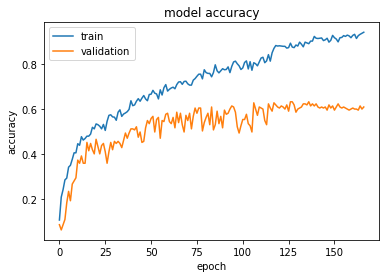

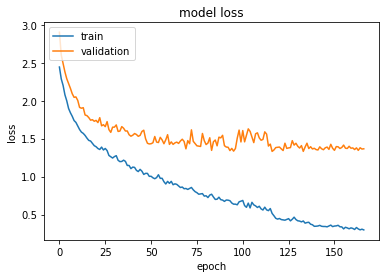

ValueError: not enough values to unpack (expected 5, got 2)

In [58]:
# summarize history for accuracy

plt.plot(history3.history['sparse_categorical_accuracy'])

plt.plot(history3.history['val_sparse_categorical_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')

plt.show()

# summarize history for loss

plt.plot(history3.history['loss'])

plt.plot(history3.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')

plt.show()

#evaluate model

loss, accuracy, f1_score, precision, recall = model3.evaluate([np.asarray(test).astype('float32')], test_target, batch_size=64, verbose=0)

#print output

print("Accuracy:{} , F1_Score:{}, Precision:{}, Recall:{}".format(accuracy, f1_score, precision, recall))

In [13]:
epochs = 400
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_v32N.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model3.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history3 = model3.fit(
    train,
    train_target,
    shuffle=True,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/200


ValueError: in user code:

    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\losses.py", line 1930, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\backend.py", line 5283, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 12) vs (None, 1)).


In [ ]:
train_target.shape

In [59]:
model4 = keras.models.load_model("best_model_v64N.h5")

test_loss, test_acc = model4.evaluate(test, test_target)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

4/4 [==============================] - 0s 38ms/step - loss: 1.1117 - sparse_categorical_accuracy: 0.6000
Test accuracy 0.6000000238418579
Test loss 1.1116721630096436


In [ ]:
X_test.shape

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
history.history["val_" + metric]

In [ ]:
history.history["val_loss"]